In [32]:
# Random Forest – Trolleys Forecasting

This notebook builds the first end-to-end forecasting baseline for `trolleys` using the GitHub-provided split files (`train_df.csv` and `test_df.csv`).

Pipeline summary  
I aggregate the data to one row per day × hub × crop type, generate time-safe features (calendar + lag/rolling statistics computed from past data only), train a Random Forest on the training period, and validate with a chronological split. The final step is to apply the same feature pipeline to the 2024 test set and export predictions.


SyntaxError: unmatched ')' (3626258561.py, line 12)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

TRAIN_PATH = "train_df.csv"
TEST_PATH  = "test_df.csv"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

print("train:", train.shape, " | test:", test.shape)
display(train.head(3))
display(test.head(3))


train: (54294, 27)  | test: (17786, 27)


,date,logistieke location id,crop_type,fpc_index,3_avg_price_per_item,3_total_items_sold,3_total_package,3_total_revenue,3_total_transactions,4_avg_price_per_item,4_total_items_sold,4_total_package,4_total_revenue,4_total_transactions,1_avg_price_per_item,1_total_items_sold,1_total_package,1_total_revenue,1_total_transactions,5_avg_price_per_item,5_total_items_sold,5_total_package,5_total_revenue,5_total_transactions,trolleys,total_issued,total_returned
0,2021-01-04,Aalsmeer,BL,fpc_1,0.21,17510.0,273.0,3683.38,48.0,0.26,46140.0,652.0,11825.7,142.0,0.24,77620.0,1213.0,18960.2,717.0,0.24,312850.0,4770.0,76058.0,1237.0,287,621375.0,771606.0
1,2021-01-04,Naaldwijk,BL,fpc_1,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.23,23390.0,351.0,5483.5,227.0,0.26,110970.0,1762.0,29005.8,553.0,106,621375.0,771606.0
2,2021-01-04,Rijnsburg,BL,fpc_1,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.25,17360.0,279.0,4349.4,167.0,0.26,50810.0,786.0,13353.9,302.0,51,621375.0,771606.0


,date,logistieke location id,crop_type,fpc_index,3_avg_price_per_item,3_total_items_sold,3_total_package,3_total_revenue,3_total_transactions,4_avg_price_per_item,4_total_items_sold,4_total_package,4_total_revenue,4_total_transactions,1_avg_price_per_item,1_total_items_sold,1_total_package,1_total_revenue,1_total_transactions,5_avg_price_per_item,5_total_items_sold,5_total_package,5_total_revenue,5_total_transactions,trolleys,total_issued,total_returned
0,2024-01-02,Aalsmeer,BL,fpc_1,0.31,44810.0,795.0,13915.2,86.0,0.3,9580.0,129.0,2882.0,48.0,0.31,53890.0,892.0,16847.8,604.0,0.24,410540.0,6640.0,97841.0,1551.0,353,531032.0,654718.0
1,2024-01-02,Naaldwijk,BL,fpc_1,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.28,14100.0,222.0,3993.7,157.0,0.22,74770.0,1183.0,16279.4,311.0,67,531032.0,654718.0
2,2024-01-02,Rijnsburg,BL,fpc_1,0.15,3000.0,30.0,450.0,5.0,0.3,9580.0,129.0,2882.0,48.0,0.33,8560.0,143.0,2863.5,93.0,0.29,40010.0,668.0,11466.8,232.0,38,531032.0,654718.0


In [2]:
def quick_overview(df, name="df"):
    print(f"== {name} ==")
    print("shape:", df.shape)
    print("\ncolumns:", list(df.columns))
    print("\nmissing (% top 15):")
    miss = (df.isna().mean().sort_values(ascending=False) * 100).head(15)
    print(miss.to_string())
    
    print("\nunique counts (categoricals-ish):")
    for c in ["date","logistieke location id","crop_type","fpc_index"]:
        if c in df.columns:
            print(f"  {c}: {df[c].nunique(dropna=True)}")

quick_overview(train, "train")
quick_overview(test, "test")


== train ==
shape: (54294, 27)

columns: ['date', 'logistieke location id', 'crop_type', 'fpc_index', '3_avg_price_per_item', '3_total_items_sold', '3_total_package', '3_total_revenue', '3_total_transactions', '4_avg_price_per_item', '4_total_items_sold', '4_total_package', '4_total_revenue', '4_total_transactions', '1_avg_price_per_item', '1_total_items_sold', '1_total_package', '1_total_revenue', '1_total_transactions', '5_avg_price_per_item', '5_total_items_sold', '5_total_package', '5_total_revenue', '5_total_transactions', 'trolleys', 'total_issued', 'total_returned']

missing (% top 15):
date                      0.0
1_avg_price_per_item      0.0
total_issued              0.0
trolleys                  0.0
5_total_transactions      0.0
5_total_revenue           0.0
5_total_package           0.0
5_total_items_sold        0.0
5_avg_price_per_item      0.0
1_total_transactions      0.0
1_total_revenue           0.0
1_total_package           0.0
1_total_items_sold        0.0
4_total_t

In [3]:
for df in [train, test]:
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")

print("train date range:", train["date"].min(), "->", train["date"].max())
print("test  date range:",  test["date"].min(),  "->",  test["date"].max())

train = train.sort_values(["date"]).reset_index(drop=True)
test  = test.sort_values(["date"]).reset_index(drop=True)


train date range: 2021-01-04 00:00:00 -> 2023-12-29 00:00:00
test  date range: 2024-01-02 00:00:00 -> 2024-12-30 00:00:00


In [4]:
KEY = ["date", "logistieke location id", "crop_type", "fpc_index"]
missing_key_cols = [c for c in KEY if c not in train.columns]
print("Missing key cols:", missing_key_cols)

if not missing_key_cols:
    dup = train.duplicated(KEY).mean() * 100
    print(f"Duplicate rows on KEY in train: {dup:.3f}%")
    if dup > 0:
        display(train[train.duplicated(KEY, keep=False)].sort_values(KEY).head(10))


Missing key cols: []
Duplicate rows on KEY in train: 0.000%


In [5]:
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
print("nb numeric cols:", len(num_cols))

# 1) négatifs
neg_cols = []
for c in num_cols:
    if (train[c] < 0).any():
        neg_cols.append(c)
print("cols with negatives:", neg_cols)

# 2) cohérence revenue ~ avg_price_per_item * total_items_sold (si les 2 existent)
candidates = [
    ("3_total_revenue","3_avg_price_per_item","3_total_items_sold"),
    ("4_total_revenue","4_avg_price_per_item","4_total_items_sold"),
]
for rev, price, items in candidates:
    if all(x in train.columns for x in [rev, price, items]):
        approx = train[price] * train[items]
        ratio = (train[rev] / approx).replace([np.inf, -np.inf], np.nan)
        print(f"\n{rev} vs {price}*{items}")
        print("ratio median:", np.nanmedian(ratio))
        print("ratio p5/p95:", np.nanpercentile(ratio, 5), np.nanpercentile(ratio, 95))


nb numeric cols: 23
cols with negatives: []

3_total_revenue vs 3_avg_price_per_item*3_total_items_sold
ratio median: 1.0
ratio p5/p95: 0.9867338415260831 1.0138814260637714

4_total_revenue vs 4_avg_price_per_item*4_total_items_sold
ratio median: 0.999995606077901
ratio p5/p95: 0.9851371130443817 1.015487084363952


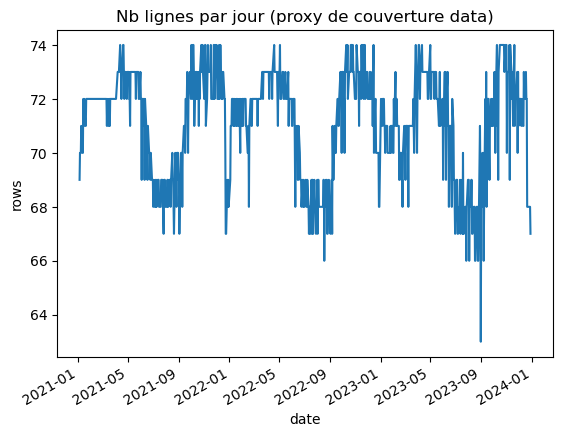

<Figure size 640x480 with 0 Axes>

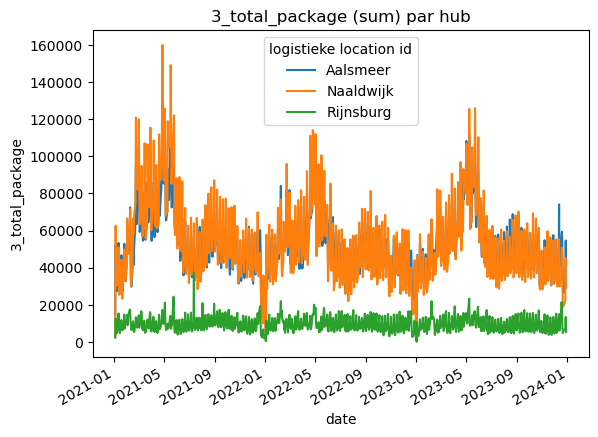

In [6]:
# Agrégé journalier (sur tout)
daily_total = train.groupby("date").size()
plt.figure()
daily_total.plot()
plt.title("Nb lignes par jour (proxy de couverture data)")
plt.ylabel("rows")
plt.show()

# Exemple: total_packages par hub (si existe)
col_pkg = "3_total_package" if "3_total_package" in train.columns else None
if col_pkg:
    tmp = train.groupby(["date","logistieke location id"])[col_pkg].sum().unstack()
    plt.figure()
    tmp.plot()
    plt.title(f"{col_pkg} (sum) par hub")
    plt.ylabel(col_pkg)
    plt.show()


In [7]:
prefix3 = sorted([c for c in train.columns if c.startswith("3_")])
prefix4 = sorted([c for c in train.columns if c.startswith("4_")])

print("3_ cols:", len(prefix3))
print(prefix3[:20])
print("\n4_ cols:", len(prefix4))
print(prefix4[:20])


3_ cols: 5
['3_avg_price_per_item', '3_total_items_sold', '3_total_package', '3_total_revenue', '3_total_transactions']

4_ cols: 5
['4_avg_price_per_item', '4_total_items_sold', '4_total_package', '4_total_revenue', '4_total_transactions']


In [8]:
# 1) types + est-ce que trolleys est entier ?
print(train[["trolleys","total_issued","total_returned"]].dtypes)
print("trolleys unique decimals example:",
      train["trolleys"].dropna().astype(float).map(lambda x: x % 1).value_counts().head(5))

# 2) corr simples
corr = train[["trolleys","total_issued","total_returned"]].corr()
display(corr)

# 3) est-ce qu'il y a une relation évidente ?
tmp = train.copy()
tmp["issued_minus_returned"] = tmp["total_issued"] - tmp["total_returned"]
tmp["issued_plus_returned"]  = tmp["total_issued"] + tmp["total_returned"]

print("Corr(trolleys, issued-returned):", tmp["trolleys"].corr(tmp["issued_minus_returned"]))
print("Corr(trolleys, issued+returned):", tmp["trolleys"].corr(tmp["issued_plus_returned"]))

# 4) check quelques lignes où ça diverge
sample = tmp.loc[:, ["date","logistieke location id","crop_type","fpc_index","trolleys","total_issued","total_returned","issued_minus_returned"]]
display(sample.sample(10, random_state=42))


trolleys            int64
total_issued      float64
total_returned    float64
dtype: object
trolleys unique decimals example: trolleys
0.0    54294
Name: count, dtype: int64


,trolleys,total_issued,total_returned
trolleys,1.000000,0.053495,0.123858
total_issued,0.053495,1.000000,0.417099
total_returned,0.123858,0.417099,1.000000


Corr(trolleys, issued-returned): -0.08479948923400364
Corr(trolleys, issued+returned): 0.11039851850446686


,date,logistieke location id,crop_type,fpc_index,trolleys,total_issued,total_returned,issued_minus_returned
30166,2022-09-01,Rijnsburg,BL,fpc_27,0,762801.0,492086.0,270715.0
12481,2021-09-13,Aalsmeer,PL,fpc_11,94,754010.0,831352.0,-77342.0
45753,2023-07-11,Rijnsburg,BL,fpc_12,3,622910.0,655329.0,-32419.0
25853,2022-06-03,Aalsmeer,BL,fpc_16,531,738638.0,851187.0,-112549.0
9194,2021-07-07,Naaldwijk,PL,fpc_19,38,549515.0,658712.0,-109197.0
3154,2021-03-05,Naaldwijk,PL,fpc_11,81,607337.0,692133.0,-84796.0
44849,2023-06-22,Aalsmeer,BL,fpc_12,36,697502.0,550642.0,146860.0
10958,2021-08-11,Aalsmeer,BL,fpc_22,1726,541305.0,569113.0,-27808.0
18111,2021-12-29,Rijnsburg,BL,fpc_2,25,548683.0,621742.0,-73059.0
45195,2023-06-29,Naaldwijk,BL,fpc_1,28,641757.0,577428.0,64329.0


In [9]:
KEY_GROUP = ["date","logistieke location id","crop_type"]

# target agrégée = somme sur fpc
agg = (train
       .groupby(KEY_GROUP, as_index=False)
       .agg(trolleys=("trolleys","sum"),
            total_issued=("total_issued","sum"),
            total_returned=("total_returned","sum")))

print("agg shape:", agg.shape)
display(agg.head())

# combien de FPC actifs par (date,loc,crop)?
fpc_count = train.groupby(KEY_GROUP)["fpc_index"].nunique().reset_index(name="n_fpc")
print(fpc_count["n_fpc"].describe())
display(fpc_count.head())


agg shape: (3820, 6)


,date,logistieke location id,crop_type,trolleys,total_issued,total_returned
0,2021-01-04,Aalsmeer,BL,8964,9942000.0,12345696.0
1,2021-01-04,Aalsmeer,PL,2010,6835125.0,8487666.0
2,2021-01-04,Naaldwijk,BL,4150,9320625.0,11574090.0
3,2021-01-04,Naaldwijk,PL,1523,6835125.0,8487666.0
4,2021-01-04,Rijnsburg,BL,2344,9942000.0,12345696.0


count    3820.000000
mean       14.213089
std         1.829363
min         9.000000
25%        12.000000
50%        15.000000
75%        16.000000
max        17.000000
Name: n_fpc, dtype: float64


,date,logistieke location id,crop_type,n_fpc
0,2021-01-04,Aalsmeer,BL,16
1,2021-01-04,Aalsmeer,PL,11
2,2021-01-04,Naaldwijk,BL,15
3,2021-01-04,Naaldwijk,PL,11
4,2021-01-04,Rijnsburg,BL,16


In [10]:
feat_cols = [c for c in train.columns if c not in ["trolleys","total_issued","total_returned"]]
print("nb features candidates:", len(feat_cols))
print(sorted(feat_cols)[:30])

# check corr brute avec target (juste pour intuition, PAS pour conclure)
num = train.select_dtypes(include=[np.number]).columns
num = [c for c in num if c not in ["trolleys","total_issued","total_returned"]]
corrs = train[num].corrwith(train["trolleys"]).sort_values(key=lambda s: s.abs(), ascending=False)
display(corrs.head(15))


nb features candidates: 24
['1_avg_price_per_item', '1_total_items_sold', '1_total_package', '1_total_revenue', '1_total_transactions', '3_avg_price_per_item', '3_total_items_sold', '3_total_package', '3_total_revenue', '3_total_transactions', '4_avg_price_per_item', '4_total_items_sold', '4_total_package', '4_total_revenue', '4_total_transactions', '5_avg_price_per_item', '5_total_items_sold', '5_total_package', '5_total_revenue', '5_total_transactions', 'crop_type', 'date', 'fpc_index', 'logistieke location id']


5_total_package         0.968386
5_total_transactions    0.963881
5_total_revenue         0.913573
5_total_items_sold      0.866915
1_total_transactions    0.849304
1_total_package         0.829137
1_total_revenue         0.823595
1_total_items_sold      0.750742
3_total_items_sold      0.595165
3_total_revenue         0.521271
4_total_items_sold      0.487711
4_total_revenue         0.382073
3_total_package         0.371345
4_total_transactions    0.323095
4_total_package         0.280378
dtype: float64

In [11]:
KEY = ["date","logistieke location id","crop_type"]

# colonnes numériques (inclut les sales_value pivotées)
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()

# target
y_col = "trolleys"

# features candidates = toutes les numériques sauf target + issued/returned (on les garde à part)
drop_now = [y_col, "total_issued", "total_returned"]
feat_num = [c for c in num_cols if c not in drop_now]

# agrégation: on somme les quantités/transactions/revenues/items/packages
# et on prend la moyenne pour les prix moyens
sum_cols = [c for c in feat_num if "avg_price" not in c]
mean_cols = [c for c in feat_num if "avg_price" in c]

agg_dict = {c: "sum" for c in sum_cols}
agg_dict.update({c: "mean" for c in mean_cols})

# on agrège aussi la target (somme sur fpc)
agg_dict[y_col] = "sum"

base = (train
        .groupby(KEY, as_index=False)
        .agg(agg_dict)
        .sort_values(KEY)
        .reset_index(drop=True))

print("base shape:", base.shape)
display(base.head())


base shape: (3820, 24)


,date,logistieke location id,crop_type,3_total_items_sold,3_total_package,3_total_revenue,3_total_transactions,4_total_items_sold,4_total_package,4_total_revenue,4_total_transactions,1_total_items_sold,1_total_package,1_total_revenue,1_total_transactions,5_total_items_sold,5_total_package,5_total_revenue,5_total_transactions,3_avg_price_per_item,4_avg_price_per_item,1_avg_price_per_item,5_avg_price_per_item,trolleys
0,2021-01-04,Aalsmeer,BL,664374.0,10617.0,199686.89,929.0,9723672.0,79956.0,1689010.07,6824.0,1833586.0,27459.0,522950.30,15526.0,16341268.0,245801.0,4110947.55,46466.0,0.266250,0.225625,0.600625,0.550000,8964
1,2021-01-04,Aalsmeer,PL,26503.0,3784.0,39507.95,225.0,1438976.0,218344.0,2471988.05,7049.0,111800.0,13211.0,181649.02,6434.0,488620.0,55928.0,633420.98,5662.0,1.535455,1.140000,2.018182,1.747273,2010
2,2021-01-04,Naaldwijk,BL,66455.0,827.0,18167.20,109.0,8557781.0,63819.0,1370463.87,5752.0,744802.0,11502.0,203326.38,7030.0,6991983.0,110583.0,1872435.22,26158.0,0.122667,0.084000,0.418667,0.430000,4150
3,2021-01-04,Naaldwijk,PL,7077.0,1939.0,25535.72,95.0,1304669.0,203140.0,2352503.05,6828.0,77416.0,8923.0,115184.40,4332.0,403465.0,43789.0,499250.67,5793.0,1.143636,0.991818,1.786364,1.623636,1523
4,2021-01-04,Rijnsburg,BL,175975.0,2275.0,41154.80,283.0,8418667.0,61319.0,1252426.95,5792.0,577215.0,8473.0,166649.95,4685.0,4731185.0,65615.0,1178890.18,16277.0,0.091875,0.067500,0.615625,0.600625,2344


In [18]:
import pandas as pd
import numpy as np

# --- checks ---
assert "trolleys" in base.columns, "Je ne trouve pas la colonne 'trolleys' dans base."

GROUP = ["logistieke location id", "crop_type"]
KEY   = ["date"] + GROUP

def add_calendar(df):
    df = df.copy()
    df["dow"] = df["date"].dt.dayofweek
    df["month"] = df["date"].dt.month
    df["week"] = df["date"].dt.isocalendar().week.astype(int)
    return df

# On commence SMART: on ne lag pas tout (sinon tu crées 500 colonnes d'un coup)
# On prend la target + quelques drivers "sales" (transactions/packages/revenue) si présents.
want = [
    "trolleys",
    "1_total_transactions","3_total_transactions","4_total_transactions","5_total_transactions",
    "1_total_package","3_total_package","4_total_package","5_total_package",
    "1_total_revenue","3_total_revenue","4_total_revenue","5_total_revenue",
]
cols = [c for c in want if c in base.columns]
print("cols used:", cols)

df = base.sort_values(KEY).copy()
df = add_calendar(df)

lags  = [7, 14, 28]
rolls = [28, 70]

g = df.groupby(GROUP, sort=False)

new = {}
for c in cols:
    for L in lags:
        new[f"{c}_lag{L}"] = g[c].shift(L)
    for R in rolls:
        new[f"{c}_rm{R}"] = g[c].transform(lambda s: s.shift(1).rolling(R).mean())
        new[f"{c}_rs{R}"] = g[c].transform(lambda s: s.shift(1).rolling(R).std())

df_feat = pd.concat([df, pd.DataFrame(new, index=df.index)], axis=1).copy()

print("df_feat shape:", df_feat.shape)
display(df_feat.head())
print("NA% top 8:")
display((df_feat.isna().mean().sort_values(ascending=False)*100).head(8))


cols used: ['trolleys', '1_total_transactions', '3_total_transactions', '4_total_transactions', '5_total_transactions', '1_total_package', '3_total_package', '4_total_package', '5_total_package', '1_total_revenue', '3_total_revenue', '4_total_revenue', '5_total_revenue']
df_feat shape: (3820, 118)


,date,logistieke location id,crop_type,3_total_items_sold,3_total_package,3_total_revenue,3_total_transactions,4_total_items_sold,4_total_package,4_total_revenue,4_total_transactions,1_total_items_sold,1_total_package,1_total_revenue,1_total_transactions,5_total_items_sold,5_total_package,5_total_revenue,5_total_transactions,3_avg_price_per_item,4_avg_price_per_item,1_avg_price_per_item,5_avg_price_per_item,trolleys,dow,month,week,trolleys_lag7,trolleys_lag14,trolleys_lag28,trolleys_rm28,trolleys_rs28,trolleys_rm70,trolleys_rs70,1_total_transactions_lag7,1_total_transactions_lag14,1_total_transactions_lag28,1_total_transactions_rm28,1_total_transactions_rs28,1_total_transactions_rm70,1_total_transactions_rs70,3_total_transactions_lag7,3_total_transactions_lag14,3_total_transactions_lag28,3_total_transactions_rm28,3_total_transactions_rs28,3_total_transactions_rm70,3_total_transactions_rs70,4_total_transactions_lag7,4_total_transactions_lag14,4_total_transactions_lag28,4_total_transactions_rm28,4_total_transactions_rs28,4_total_transactions_rm70,4_total_transactions_rs70,5_total_transactions_lag7,5_total_transactions_lag14,5_total_transactions_lag28,5_total_transactions_rm28,5_total_transactions_rs28,5_total_transactions_rm70,5_total_transactions_rs70,1_total_package_lag7,1_total_package_lag14,1_total_package_lag28,1_total_package_rm28,1_total_package_rs28,1_total_package_rm70,1_total_package_rs70,3_total_package_lag7,3_total_package_lag14,3_total_package_lag28,3_total_package_rm28,3_total_package_rs28,3_total_package_rm70,3_total_package_rs70,4_total_package_lag7,4_total_package_lag14,4_total_package_lag28,4_total_package_rm28,4_total_package_rs28,4_total_package_rm70,4_total_package_rs70,5_total_package_lag7,5_total_package_lag14,5_total_package_lag28,5_total_package_rm28,5_total_package_rs28,5_total_package_rm70,5_total_package_rs70,1_total_revenue_lag7,1_total_revenue_lag14,1_total_revenue_lag28,1_total_revenue_rm28,1_total_revenue_rs28,1_total_revenue_rm70,1_total_revenue_rs70,3_total_revenue_lag7,3_total_revenue_lag14,3_total_revenue_lag28,3_total_revenue_rm28,3_total_revenue_rs28,3_total_revenue_rm70,3_total_revenue_rs70,4_total_revenue_lag7,4_total_revenue_lag14,4_total_revenue_lag28,4_total_revenue_rm28,4_total_revenue_rs28,4_total_revenue_rm70,4_total_revenue_rs70,5_total_revenue_lag7,5_total_revenue_lag14,5_total_revenue_lag28,5_total_revenue_rm28,5_total_revenue_rs28,5_total_revenue_rm70,5_total_revenue_rs70
0,2021-01-04,Aalsmeer,BL,664374.0,10617.0,199686.89,929.0,9723672.0,79956.0,1689010.07,6824.0,1833586.0,27459.0,522950.30,15526.0,16341268.0,245801.0,4110947.55,46466.0,0.266250,0.225625,0.600625,0.550000,8964,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-04,Aalsmeer,PL,26503.0,3784.0,39507.95,225.0,1438976.0,218344.0,2471988.05,7049.0,111800.0,13211.0,181649.02,6434.0,488620.0,55928.0,633420.98,5662.0,1.535455,1.140000,2.018182,1.747273,2010,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-04,Naaldwijk,BL,66455.0,827.0,18167.20,109.0,8557781.0,63819.0,1370463.87,5752.0,744802.0,11502.0,203326.38,7030.0,6991983.0,110583.0,1872435.22,26158.0,0.122667,0.084000,0.418667,0.430000,4150,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

NA% top 8:


5_total_revenue_rs70         9.162304
1_total_package_rs70         9.162304
4_total_transactions_rm70    9.162304
4_total_package_rm70         9.162304
3_total_package_rs70         9.162304
trolleys_rm70                9.162304
trolleys_rs70                9.162304
3_total_package_rm70         9.162304
dtype: float64

In [19]:
from sklearn.metrics import mean_absolute_error

# On drop les lignes sans historique (normal)
model_df = df_feat.dropna().reset_index(drop=True)
print("model_df shape:", model_df.shape)

# split temporel simple
cut = pd.Timestamp("2023-07-01")
train_part = model_df[model_df["date"] < cut]
val_part   = model_df[model_df["date"] >= cut]

# baseline = trolleys semaine dernière
pred = val_part["trolleys_lag7"]
mae = mean_absolute_error(val_part["trolleys"], pred)

print("Baseline MAE (lag7):", mae)


model_df shape: (3470, 118)
Baseline MAE (lag7): 956.5765625


Baseline MAE (lag7): 956.5765625
RF MAE: 131.13892353347603
RF improvement (%): 86.29080737763988


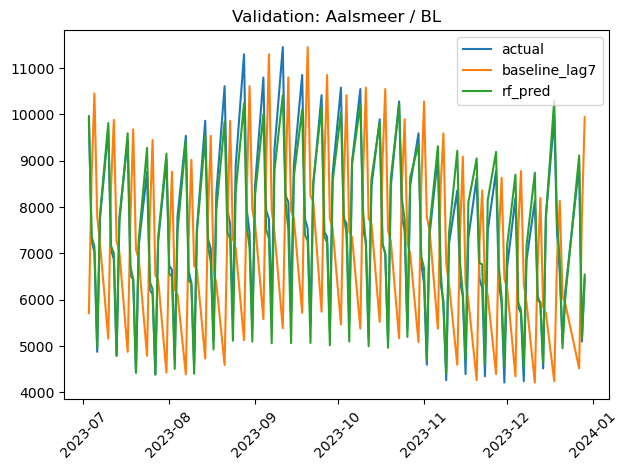


Top 20 feature importances:
5_total_transactions                          0.8673
5_total_package                               0.0937
5_total_items_sold                            0.0120
1_total_package                               0.0035
trolleys_rm28                                 0.0020
1_total_transactions                          0.0017
3_total_package_rm70                          0.0013
trolleys_lag14                                0.0009
trolleys_rm70                                 0.0009
trolleys_rs70                                 0.0008
trolleys_lag7                                 0.0008
3_total_transactions_rm70                     0.0007
5_total_revenue_rs70                          0.0007
trolleys_rs28                                 0.0007
1_total_transactions_rm28                     0.0005
5_total_package_rs70                          0.0005
1_total_package_rm28                          0.0005
5_total_package_rm70                          0.0005
4_total_transacti

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

y_col = "trolleys"
cut = pd.Timestamp("2023-07-01")

train_part = model_df[model_df["date"] < cut].copy()
val_part   = model_df[model_df["date"] >= cut].copy()

# X / y
drop_cols = ["date", y_col]  # on garde hub + crop_type (cat) + features numériques
X_train = train_part.drop(columns=drop_cols)
y_train = train_part[y_col]
X_val   = val_part.drop(columns=drop_cols)
y_val   = val_part[y_col]

# colonnes
cat_cols = [c for c in ["logistieke location id", "crop_type"] if c in X_train.columns]
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median"))
        ]), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    max_depth=None,
    min_samples_leaf=2
)

model = Pipeline(steps=[("prep", preprocess), ("rf", rf)])
model.fit(X_train, y_train)

# predictions
pred_val = model.predict(X_val)

# metrics
mae_rf = mean_absolute_error(y_val, pred_val)
mae_base = mean_absolute_error(y_val, val_part["trolleys_lag7"])

print("Baseline MAE (lag7):", mae_base)
print("RF MAE:", mae_rf)
print("RF improvement (%):", (mae_base - mae_rf) / mae_base * 100)

# --- Plot pred vs actual (time series)
plot_df = val_part[["date","logistieke location id","crop_type", y_col]].copy()
plot_df["pred_rf"] = pred_val
plot_df["pred_base"] = val_part["trolleys_lag7"].values

# On plot un seul segment (sinon c'est illisible): choisis le combo le plus fréquent
combo = (plot_df.groupby(["logistieke location id","crop_type"]).size().sort_values(ascending=False).index[0])
loc0, crop0 = combo

sub = plot_df[(plot_df["logistieke location id"]==loc0) & (plot_df["crop_type"]==crop0)].sort_values("date")

plt.figure()
plt.plot(sub["date"], sub[y_col], label="actual")
plt.plot(sub["date"], sub["pred_base"], label="baseline_lag7")
plt.plot(sub["date"], sub["pred_rf"], label="rf_pred")
plt.title(f"Validation: {loc0} / {crop0}")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# --- Feature importance (top 20)
prep = model.named_steps["prep"]
rf_fitted = model.named_steps["rf"]

# récupérer les noms après one-hot
feat_names_num = num_cols
feat_names_cat = list(prep.named_transformers_["cat"].get_feature_names_out(cat_cols)) if cat_cols else []
feat_names = feat_names_num + feat_names_cat

importances = rf_fitted.feature_importances_
idx = np.argsort(importances)[::-1][:20]

print("\nTop 20 feature importances:")
for i in idx:
    print(f"{feat_names[i]:<45} {importances[i]:.4f}")


In [21]:
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

GROUP = ["logistieke location id","crop_type"]

df = model_df.sort_values(["date"] + GROUP).copy()
g = df.groupby(GROUP, sort=False)

# targets future
df["y_lead7"]  = g["trolleys"].shift(-7)
df["y_lead28"] = g["trolleys"].shift(-28)
df["y_lead70"] = g["trolleys"].shift(-70)

# on garde uniquement les colonnes "safe" = lags/rolling + calendrier + categoriels
# => on drop toutes les colonnes "instant t" qui pourraient fuiter.
safe_cols = [c for c in df.columns if (
    c in ["date","logistieke location id","crop_type"] or
    c.startswith("trolleys_") or "_lag" in c or "_rm" in c or "_rs" in c or
    c in ["dow","week","month"]
)]
df_safe = df[safe_cols + ["y_lead7","y_lead28","y_lead70"]].dropna().reset_index(drop=True)

print("df_safe:", df_safe.shape, "cols:", len(df_safe.columns))

def fit_eval(target_col):
    cut = pd.Timestamp("2023-07-01")
    tr = df_safe[df_safe["date"] < cut].copy()
    va = df_safe[df_safe["date"] >= cut].copy()

    X_tr = tr.drop(columns=["date","y_lead7","y_lead28","y_lead70"])
    y_tr = tr[target_col]
    X_va = va.drop(columns=["date","y_lead7","y_lead28","y_lead70"])
    y_va = va[target_col]

    cat_cols = [c for c in ["logistieke location id","crop_type"] if c in X_tr.columns]
    num_cols = [c for c in X_tr.columns if c not in cat_cols]

    preprocess = ColumnTransformer([
        ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ])

    rf = RandomForestRegressor(
        n_estimators=400, random_state=42, n_jobs=-1, min_samples_leaf=2
    )

    model = Pipeline([("prep", preprocess), ("rf", rf)])
    model.fit(X_tr, y_tr)
    pred = model.predict(X_va)

    mae = mean_absolute_error(y_va, pred)
    print(target_col, "MAE:", mae)
    return mae

mae7  = fit_eval("y_lead7")
mae28 = fit_eval("y_lead28")
mae70 = fit_eval("y_lead70")


df_safe: (3120, 100) cols: 100
y_lead7 MAE: 356.8868497145097
y_lead28 MAE: 338.31420667967075
y_lead70 MAE: 352.72247406582875


In [22]:
import numpy as np
import pandas as pd

GROUP = ["logistieke location id","crop_type"]

def best_shift_corr(df, col_a, col_b, shifts=range(-42,43)):
    # corr(col_a[t], col_b[t+shift]) sur toutes les séries groupées
    tmp = df.sort_values(["date"] + GROUP).copy()
    g = tmp.groupby(GROUP, sort=False)
    best = None

    for s in shifts:
        # on shift col_b à l'intérieur de chaque groupe
        b = g[col_b].shift(s)
        corr = pd.concat([tmp[col_a], b], axis=1).dropna().corr().iloc[0,1]
        if best is None or abs(corr) > abs(best[1]):
            best = (s, corr)
    return best

metrics = ["total_transactions","total_package","total_revenue","total_items_sold","avg_price_per_item"]

for m in metrics:
    a = f"1_{m}"
    b = f"3_{m}"
    if a in base.columns and b in base.columns:
        s, c = best_shift_corr(base, a, b, shifts=range(-60,61))
        print(f"{a} vs {b}: best shift={s} days, corr={c:.3f}")


1_total_transactions vs 3_total_transactions: best shift=-8 days, corr=-0.255
1_total_package vs 3_total_package: best shift=-1 days, corr=0.337
1_total_revenue vs 3_total_revenue: best shift=-1 days, corr=0.502
1_total_items_sold vs 3_total_items_sold: best shift=-1 days, corr=0.919
1_avg_price_per_item vs 3_avg_price_per_item: best shift=-1 days, corr=0.919


In [23]:
def corr_with_shifted_target(df, x, shifts=[0,7,14,28,70]):
    tmp = df.sort_values(["date"] + GROUP).copy()
    g = tmp.groupby(GROUP, sort=False)
    out = {}
    for s in shifts:
        y = g["trolleys"].shift(-s)  # -s = target futur (lead)
        out[s] = pd.concat([tmp[x], y], axis=1).dropna().corr().iloc[0,1]
    return out

x = "5_total_transactions"
if x in base.columns:
    out = corr_with_shifted_target(base, x, shifts=[0,7,28,70])
    print("corr(x, trolleys_leadK) where K in {0,7,28,70}:")
    for k,v in out.items():
        print(f"K={k:>2}: corr={v:.3f}")


corr(x, trolleys_leadK) where K in {0,7,28,70}:
K= 0: corr=0.956
K= 7: corr=0.752
K=28: corr=0.781
K=70: corr=0.810


clean forecasting dataset: (3120, 100)
y7 MAE: 357.215685533413
y28 MAE: 339.2149564745023
y70 MAE: 351.4270811813092


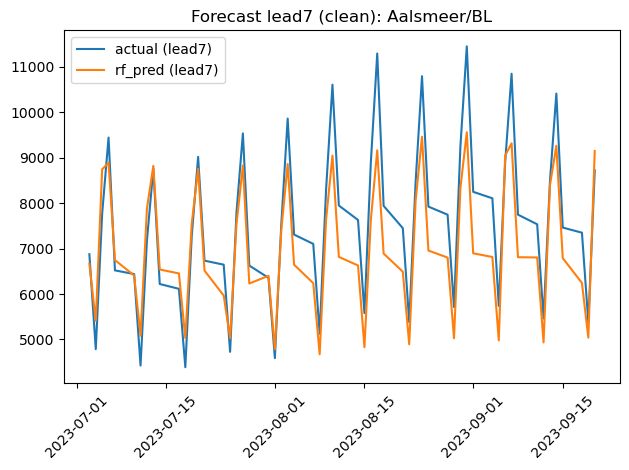

In [24]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

GROUP = ["logistieke location id","crop_type"]
cut = pd.Timestamp("2023-07-01")

df = df_feat.sort_values(["date"] + GROUP).copy()
g = df.groupby(GROUP, sort=False)

# targets futurs
df["y7"]  = g["trolleys"].shift(-7)
df["y28"] = g["trolleys"].shift(-28)
df["y70"] = g["trolleys"].shift(-70)

# ---- features CLEAN: pas de 1_/3_/4_/5_ "raw"
# on garde uniquement:
# - cat: hub/crop
# - calendar: dow/week/month
# - lag/rolling: colonnes qui contiennent _lag / _rm / _rs
keep_X = []
for c in df.columns:
    if c in ["logistieke location id","crop_type","dow","week","month"]:
        keep_X.append(c)
    elif ("_lag" in c) or ("_rm" in c) or ("_rs" in c):
        keep_X.append(c)

data = df[["date"] + keep_X + ["y7","y28","y70"]].dropna().reset_index(drop=True)
print("clean forecasting dataset:", data.shape)

def fit_one(target):
    tr = data[data["date"] < cut].copy()
    va = data[data["date"] >= cut].copy()

    X_tr = tr.drop(columns=["date","y7","y28","y70"])
    y_tr = tr[target]
    X_va = va.drop(columns=["date","y7","y28","y70"])
    y_va = va[target]

    cat_cols = [c for c in ["logistieke location id","crop_type"] if c in X_tr.columns]
    num_cols = [c for c in X_tr.columns if c not in cat_cols]

    prep = ColumnTransformer([
        ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ])

    rf = RandomForestRegressor(
        n_estimators=500,
        random_state=42,
        n_jobs=-1,
        min_samples_leaf=2
    )

    model = Pipeline([("prep", prep), ("rf", rf)])
    model.fit(X_tr, y_tr)
    pred = model.predict(X_va)

    mae = mean_absolute_error(y_va, pred)
    print(target, "MAE:", mae)

    return model, va[["date","logistieke location id","crop_type"]].copy(), y_va.values, pred

m7, meta7, y_true7, pred7 = fit_one("y7")
m28, meta28, y_true28, pred28 = fit_one("y28")
m70, meta70, y_true70, pred70 = fit_one("y70")

# plot sur le segment le plus fréquent (pour lisibilité)
plot_df = meta7.copy()
plot_df["y_true"] = y_true7
plot_df["pred"] = pred7
combo = plot_df.groupby(["logistieke location id","crop_type"]).size().sort_values(ascending=False).index[0]
loc0, crop0 = combo

sub = plot_df[(plot_df["logistieke location id"]==loc0) & (plot_df["crop_type"]==crop0)].sort_values("date")

plt.figure()
plt.plot(sub["date"], sub["y_true"], label="actual (lead7)")
plt.plot(sub["date"], sub["pred"], label="rf_pred (lead7)")
plt.title(f"Forecast lead7 (clean): {loc0}/{crop0}")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [28]:
# 0) Choisis le bon df ici : model_df OU data OU df_feat (celui qui sert au split)
df_check = model_df.copy()  # <- change en data ou df_feat si besoin

cut = pd.Timestamp("2023-07-01")

print("df_check date range:", df_check["date"].min(), "->", df_check["date"].max())
print("rows total:", len(df_check))

tr = df_check[df_check["date"] < cut]
va = df_check[df_check["date"] >= cut]

print("\nTRAIN PART")
print("rows:", len(tr))>
print("date range:", tr["date"].min(), "->", tr["date"].max())

print("\nVAL PART")
print("rows:", len(va))
print("date range:", va["date"].min(), "->", va["date"].max())


df_check date range: 2021-04-13 00:00:00 -> 2023-12-29 00:00:00
rows total: 3470

TRAIN PART
rows: 2830
date range: 2021-04-13 00:00:00 -> 2023-06-30 00:00:00

VAL PART
rows: 640
date range: 2023-07-03 00:00:00 -> 2023-12-29 00:00:00


In [29]:
import pandas as pd
import numpy as np

TRAIN_PATH = "train_df.csv"
TEST_PATH  = "test_df.csv"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

# parse dates
for df in (train, test):
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

KEY = ["date", "logistieke location id", "crop_type"]
y_col = "trolleys"

def make_base(df):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # si jamais le test contient déjà trolleys, on l'ignore côté features,
    # mais on garde la colonne si elle existe.
    drop_now = [y_col, "total_issued", "total_returned"]
    feat_num = [c for c in num_cols if c not in drop_now]

    sum_cols  = [c for c in feat_num if "avg_price" not in c]
    mean_cols = [c for c in feat_num if "avg_price" in c]

    agg_dict = {c: "sum" for c in sum_cols}
    agg_dict.update({c: "mean" for c in mean_cols})

    # target agrégée uniquement si présente
    if y_col in df.columns:
        agg_dict[y_col] = "sum"

    base = (df.groupby(KEY, as_index=False)
              .agg(agg_dict)
              .sort_values(KEY)
              .reset_index(drop=True))
    return base

base_tr = make_base(train)
base_te = make_base(test)

print("base_tr:", base_tr.shape, "| date:", base_tr["date"].min(), "->", base_tr["date"].max())
print("base_te:", base_te.shape, "| date:", base_te["date"].min(), "->", base_te["date"].max())


base_tr: (3820, 24) | date: 2021-01-04 00:00:00 -> 2023-12-29 00:00:00
base_te: (1275, 24) | date: 2024-01-02 00:00:00 -> 2024-12-30 00:00:00


In [30]:
GROUP = ["logistieke location id", "crop_type"]

def add_calendar(df):
    df = df.copy()
    df["dow"]   = df["date"].dt.dayofweek
    df["month"] = df["date"].dt.month
    df["week"]  = df["date"].dt.isocalendar().week.astype(int)
    return df

def add_lag_roll(df, cols, lags=(7,14,28), rolls=(28,70)):
    df = df.sort_values(["date"] + GROUP).copy()
    g = df.groupby(GROUP, sort=False)

    new = {}
    for c in cols:
        for L in lags:
            new[f"{c}_lag{L}"] = g[c].shift(L)
        for R in rolls:
            new[f"{c}_rm{R}"] = g[c].transform(lambda s: s.shift(1).rolling(R).mean())
            new[f"{c}_rs{R}"] = g[c].transform(lambda s: s.shift(1).rolling(R).std())

    return pd.concat([df, pd.DataFrame(new, index=df.index)], axis=1)

# concat pour que le début du test profite de l'historique train
base_tr["_is_train"] = 1
base_te["_is_train"] = 0

base_all = pd.concat([base_tr, base_te], ignore_index=True)

# features candidates (on évite d’inclure la target dans les lags par défaut)
# -> on lag seulement des drivers "sales" + éventuellement trolleys si tu veux
want = [
    "1_total_transactions","3_total_transactions","4_total_transactions","5_total_transactions",
    "1_total_package","3_total_package","4_total_package","5_total_package",
    "1_total_revenue","3_total_revenue","4_total_revenue","5_total_revenue",
    "1_total_items_sold","3_total_items_sold","4_total_items_sold","5_total_items_sold",
    # si tu veux aussi lagger trolleys, décommente :
    # "trolleys",
]
cols_lag = [c for c in want if c in base_all.columns]
print("Lag/Roll columns:", cols_lag)

feat_all = add_calendar(base_all)
feat_all = add_lag_roll(feat_all, cols=cols_lag, lags=(7,14,28), rolls=(28,70))

feat_tr = feat_all[feat_all["_is_train"]==1].drop(columns=["_is_train"]).reset_index(drop=True)
feat_te = feat_all[feat_all["_is_train"]==0].drop(columns=["_is_train"]).reset_index(drop=True)

print("feat_tr:", feat_tr.shape, "| feat_te:", feat_te.shape)


Lag/Roll columns: ['1_total_transactions', '3_total_transactions', '4_total_transactions', '5_total_transactions', '1_total_package', '3_total_package', '4_total_package', '5_total_package', '1_total_revenue', '3_total_revenue', '4_total_revenue', '5_total_revenue', '1_total_items_sold', '3_total_items_sold', '4_total_items_sold', '5_total_items_sold']
feat_tr: (3820, 139) | feat_te: (1275, 139)


In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

# y dans train obligatoire
assert y_col in feat_tr.columns, "Ton train agrégé n'a pas 'trolleys' -> check make_base()"

# X/y
drop_cols = ["date", y_col]  # date pas utilisée par RF (on a déjà dow/week/month)
X_train = feat_tr.drop(columns=drop_cols)
y_train = feat_tr[y_col]

# colonnes cat/num
cat_cols = [c for c in ["logistieke location id", "crop_type"] if c in X_train.columns]
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

rf = RandomForestRegressor(
    n_estimators=600,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=2
)

model = Pipeline([("prep", preprocess), ("rf", rf)])
model.fit(X_train, y_train)

# --- predict test ---
X_test = feat_te.drop(columns=["date"], errors="ignore")
if y_col in X_test.columns:
    X_test = X_test.drop(columns=[y_col])  # au cas où le test contient la vraie target

pred_test = model.predict(X_test)

# format submission (adapte si ton template impose un nom précis)
sub = feat_te[KEY].copy()
sub["trolleys"] = pred_test  # souvent attendu: la colonne target porte le même nom
sub.to_csv("submission.csv", index=False)

print(sub.head())
print("\nSaved -> submission.csv")


        date logistieke location id crop_type     trolleys
0 2024-01-02               Aalsmeer        BL  8967.134478
1 2024-01-02               Aalsmeer        PL  2091.645899
2 2024-01-02              Naaldwijk        BL  2642.604057
3 2024-01-02              Naaldwijk        PL  1425.922201
4 2024-01-02              Rijnsburg        BL  1806.433336

Saved -> submission.csv


In [34]:
# --- RESULTS 

from sklearn.metrics import mean_absolute_error

y_col = "trolleys"
cut = pd.Timestamp("2023-07-01")

train_part = model_df[model_df["date"] < cut].copy()
val_part   = model_df[model_df["date"] >= cut].copy()

# baseline
mae_base = mean_absolute_error(val_part[y_col], val_part[f"{y_col}_lag7"])

# RF predictions must already exist as pred_val (from your RF cell)
# If your variable name is different, change pred_val below.
mae_rf = mean_absolute_error(val_part[y_col], pred_val)

print("model_df shape:", model_df.shape)
print("Baseline MAE (lag7):", mae_base)
print("RF MAE:", mae_rf)
print("RF improvement (%):", (mae_base - mae_rf) / mae_base * 100)


model_df shape: (3470, 118)
Baseline MAE (lag7): 956.5765625
RF MAE: 131.13892353347603
RF improvement (%): 86.29080737763988
